## Installation des librairies

In [6]:
!pip install openslide-bin
!pip install openslide-python
!pip install opencv-python
!pip install ipython
!pip install natsort


[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
!pip freeze | grep natsort

natsort==8.4.0


## 1. Import des librairies

##  1.1 import

In [37]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os
from PIL import Image
import numpy as np
import openslide
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
from pathlib import Path
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor
import csv


%load_ext autoreload
%autoreload 2


Min_SIZE_MB = 5 # Taille min par tuile (en Mo)
tile_size_l = 4096
tile_size_h = 2048  # Taille des tuiles
level = 0  # Niveau de zoom OpenSlide (0 = max résolution)
train_tumor_path = "/mnt/c/Users/grego/Documents/Projet_ML/Data/Dataset/train/tumor"
train_normal_path = "/mnt/c/Users/grego/Documents/Projet_ML/Data/Dataset/train/normal"
treated_tumor_path='/mnt/c/Users/grego/Documents/Projet_ML/Data/TREATED/tumor'
treated_normal_path='/mnt/c/Users/grego/Documents/Projet_ML/Data/TREATED/normal'
totreat_tumor_path = '/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/tumor'
totreat_normal_path = '/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/normal'

os.environ["OMP_NUM_THREADS"] = "16"  # Ajustez selon votre nombre de cœurs
os.environ["MKL_NUM_THREADS"] = "16"
input_path = "/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/tumor" # / a la fin
val_path='/mnt/c/Users/grego/Documents/Projet_ML/Data/Dataset/val'
train_path='/mnt/c/Users/grego/Documents/Projet_ML/Data/Dataset/train'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fonction de chargement du fichier mrxs

In [ ]:
#Load file mrxs and create a thumbnail
def load_slide2(file, source):
    filename = f"{file}.mrxs"
    path_to_slide = os.path.join(source,filename)
    print(path_to_slide)
    #with open(path_to_slide, "r") as f:
    #   contenu = f.read()
    slide = openslide.OpenSlide(path_to_slide)
    # Récupérer une miniature pour analyse (taille réduite pour traitement rapide)
    thumbnail = slide.get_thumbnail((1024, 2048))  # Ajuster la taille selon l’image
    # Convertir en format OpenCV
    thumbnail_np = np.array(thumbnail.convert("RGB"))
    return slide, thumbnail_np


# Définir la zone (coordonnées x, y et taille du patch)
#x, y = 50000, 110000  # Coordonnées de départ
#width, height = 10000, 10000  # Taille de l'extrait

## Extraire une région de l'image
#region = slide.read_region((x, y), level=0, size=(width, height))
## Convertir l'image pour affichage
#region = region.convert("RGB")
#region.show()  # Ouvre l'image

## FONCTION DE DEFINITION DES CONTOURS

In [ ]:

def contour_cells(thumbnail_np):
    # Convertir l’image en HSV
    hsv = cv2.cvtColor(thumbnail_np, cv2.COLOR_RGB2HSV)

    # Définir les plages de couleur pour détecter le rose
    lower_pink = np.array([110,0 , 0])   # Valeurs min HSV
    upper_pink = np.array([180, 255, 255])  # Valeurs max HSV

    # Masque des zones contenant du tissu
    mask = cv2.inRange(hsv, lower_pink, upper_pink)

    # Trouver les contours des zones roses
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Dessiner les contours sur l’image originale
    contour_image = thumbnail_np.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

    # Afficher l’image avec les contours détectés
    image_to_show = Image.fromarray(contour_image)

    return image_to_show, mask, contours

## Affichage du MASK

In [ ]:
import matplotlib.pyplot as plt

# Afficher le masque avec Matplotlib
plt.imshow(mask, cmap="gray")
plt.title("Masque du Tissu")
plt.axis("off")
plt.show()

## TROUVER DES CONTOURS DANS LES ZONES ROSES

In [ ]:
# Trouver les contours des zones roses
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dessiner les contours sur l’image originale
contour_image = thumbnail_np.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Afficher l’image avec les contours détectés
image_to_show = Image.fromarray(contour_image)
plt.imshow(image_to_show)
plt.title("Contour à découper")
plt.axis("off")
plt.show()


In [31]:
# Pour TensorFlow
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))


2025-03-07 18:04:32.663411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-07 18:04:32.717951: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU disponible: []


In [32]:
# Pour PyTorch
import torch
print("GPU disponible:", torch.cuda.is_available())
print("Nombre de GPUs:", torch.cuda.device_count())

GPU disponible: False
Nombre de GPUs: 0


## FONCTION DE CUT DES LAMES

In [4]:
## NOUVELLE VERSION du CUT ##

def slide_cut(slide, thumbnail_np, contours, filename,
              output_path, level=0, tile_size_l=tile_size_l, tile_size_h=tile_size_h,
              min_size_mb=Min_SIZE_MB, max_workers=8, global_csv_path="all_tiles_coordinates.csv"):
    """
    Découpe une lame (slide) en tuiles selon les contours détectés et sauvegarde leurs coordonnées.

    Args:
        slide: Objet OpenSlide contenant l'image de la lame
        thumbnail_np: Miniature de la lame sous forme de tableau numpy
        contours: Liste des contours détectés dans la miniature
        filename: Nom du fichier source pour nommer les tuiles
        output_path: Chemin de sortie pour sauvegarder les tuiles
        level: Niveau de résolution à utiliser (défaut: 0, résolution maximale)
        tile_size_l: Largeur des tuiles en pixels (défaut: 256)
        tile_size_h: Hauteur des tuiles en pixels (défaut: 256)
        min_size_mb: Taille minimale des tuiles en Mo (défaut: 0.01)
        max_workers: Nombre de threads pour le traitement parallèle (défaut: 4)

    Returns:
        tuple: (nombre_tuiles, temps_execution)
    """
    # Assurer que le dossier de sortie existe
    output_dir = Path(output_path)
    output_dir.mkdir(parents=True, exist_ok=True)

    # S'assurer que le nom de fichier est complet (avec le chemin d'accès)
    # Stocker le nom de fichier complet (avec l'extension) pour la recherche ultérieure
    full_filename = os.path.basename(filename)

    # Vérifier si le fichier CSV global existe, sinon le créer avec des en-têtes
    global_csv_path = os.path.join(output_path, global_csv_path)
    csv_file_exists = os.path.isfile(global_csv_path)

    # Préparer le fichier CSV avec les en-têtes
    if not csv_file_exists:
        with open(global_csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['slide_filename', 'tile_filename', 'contour_idx', 'x_original', 'y_original',
                             'width', 'height', 'x_thumbnail', 'y_thumbnail',
                             'w_thumbnail', 'h_thumbnail'])

    # Calculer le facteur d'échelle entre la miniature et l'image originale
    scale_x = slide.dimensions[0] / thumbnail_np.shape[1]
    scale_y = slide.dimensions[1] / thumbnail_np.shape[0]

    print(f"Début du traitement du fichier {full_filename}...")
    start_time = time.time()  # Début du chronomètre

    # Liste pour stocker les tâches de découpage
    tiles_to_process = []

    # Préparer la liste des tuiles à extraire
    for contour_idx, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)  # Récupérer les coordonnées dans la miniature

        # Convertir en coordonnées de l'image OpenSlide (grande taille)
        x_slide = int(x * scale_x)
        y_slide = int(y * scale_y)
        w_slide = int(w * scale_x)
        h_slide = int(h * scale_y)

        # Récupérer les coordonnées de toutes les tuiles dans cette zone
        for i in range(x_slide, x_slide + w_slide, tile_size_l):
            for j in range(y_slide, y_slide + h_slide, tile_size_h):
                # Ajouter cette tuile à la liste des tuiles à traiter
                tile_info = {
                    'position': (i, j),
                    'contour_idx': contour_idx,
                    'row': (i - x_slide) // tile_size_l,
                    'col': (j - y_slide) // tile_size_h,
                    'thumbnail_coords': (x, y, w, h)  # Coordonnées dans la miniature
                }
                tiles_to_process.append(tile_info)

    def process_tile(tile_info):
        """Fonction qui traite une tuile individuelle"""
        try:
            i, j = tile_info['position']
            contour_idx = tile_info['contour_idx']
            row, col = tile_info['row'], tile_info['col']
            x_thumb, y_thumb, w_thumb, h_thumb = tile_info['thumbnail_coords']

            # Extraire la tuile
            tile = slide.read_region((i, j), level, (tile_size_l, tile_size_h))

            # Vérifier la taille avant sauvegarde
            buffer = BytesIO()
            tile.save(buffer, format="PNG")
            file_size_mb = len(buffer.getvalue()) / (1024 * 1024)

            if file_size_mb > min_size_mb:
                # Créer un nom de fichier plus informatif
                tile_filename = f"tile_{full_filename}_c{contour_idx}_r{row}_c{col}.png"
                tile_path = os.path.join(output_path, tile_filename)
                tile.save(tile_path)

                # Ajouter les coordonnées à la liste qui sera écrite dans le CSV
                return [
                    full_filename,            # Nom du fichier original
                    tile_filename,        # Nom du fichier de la tuile
                    contour_idx,          # Indice du contour
                    i,                    # Position X dans l'image originale
                    j,                    # Position Y dans l'image originale
                    tile_size_l,          # Largeur de la tuile
                    tile_size_h,          # Hauteur de la tuile
                    x_thumb,              # Position X dans la miniature
                    y_thumb,              # Position Y dans la miniature
                    w_thumb,              # Largeur du contour dans la miniature
                    h_thumb               # Hauteur du contour dans la miniature
                ]

            return None  # Indique que la tuile n'a pas été sauvegardée car trop petite

        except Exception as e:
            print(f"Erreur lors du traitement d'une tuile: {e}")
            return False

    # Traiter les tuiles en parallèle
    saved_tiles_data = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(process_tile, tiles_to_process))
        # Filtrer les résultats None (tuiles non sauvegardées)
        saved_tiles_data = [result for result in results if result is not None]

    # Écrire toutes les coordonnées dans le fichier CSV global
    if saved_tiles_data:
        with open(global_csv_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerows(saved_tiles_data)

    # Calculer le temps d'exécution
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Fin du traitement du fichier {full_filename} en {execution_time:.2f} secondes")
    print(f"{len(saved_tiles_data)} tuiles générées à partir du fichier {full_filename}")
    print(f"Coordonnées ajoutées au fichier global: {global_csv_path}")

    return len(saved_tiles_data), execution_time, global_csv_path


## EXECUTION DE LA BOUCLE DE TRAITEMENT DES IMAGES

In [5]:
## EXECUTION DU CUT SUR LE REPERTOIRE INPUT_PATH
source = totreat_normal_path
target = train_normal_path
files = list(Path(source).glob('*.mrxs'))
for file in files:
    filename = file.name.split(sep=".")[0]
    slide, thumbnail_np = load_slide(filename,source)
    image, mask, contour = contour_cells(thumbnail_np)
    #slide_cut(slide,thumbnail_np, contour,filename)
    saved_tiles, execution_time, coords_file = slide_cut(slide, thumbnail_np, contour, filename, target)

/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/normal/RB05762.mrxs
Début du traitement du fichier RB05762...
Fin du traitement du fichier RB05762 en 519.83 secondes
687 tuiles générées à partir du fichier RB05762
Coordonnées ajoutées au fichier global: /mnt/c/Users/grego/Documents/Projet_ML/Data/Dataset/train/normal/all_tiles_coordinates.csv
/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/normal/RB05765.mrxs
Début du traitement du fichier RB05765...
Fin du traitement du fichier RB05765 en 127.28 secondes
100 tuiles générées à partir du fichier RB05765
Coordonnées ajoutées au fichier global: /mnt/c/Users/grego/Documents/Projet_ML/Data/Dataset/train/normal/all_tiles_coordinates.csv
/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/normal/RB05780.mrxs
Début du traitement du fichier RB05780...
Fin du traitement du fichier RB05780 en 132.35 secondes
125 tuiles générées à partir du fichier RB05780
Coordonnées ajoutées au fichier global: /mnt/c/Users/grego/Documents/Projet_ML/Data/

## FONCTION DE SELECTION DE FICHIER ALEATOIRE POUR GENERATION DES ECHANTILLON

In [2]:
from anapath.image.manip import select_random_files_by_index
from anapath.params import *


selected_file = select_random_files_by_index(train_normal_path,15)


['all_tiles_coordinates.csv', 'tile_02228_c132_r10_c2.png', 'tile_02228_c132_r10_c3.png', 'tile_02228_c132_r1_c5.png', 'tile_02228_c132_r2_c6.png', 'tile_02228_c132_r3_c6.png', 'tile_02229_c288_r10_c36.png', 'tile_02229_c288_r10_c37.png', 'tile_02229_c288_r10_c38.png', 'tile_02229_c288_r12_c21.png', 'tile_02229_c288_r15_c40.png', 'tile_02229_c288_r15_c44.png', 'tile_02229_c288_r6_c36.png', 'tile_02229_c288_r6_c4.png', 'tile_02229_c288_r7_c35.png', 'tile_02229_c288_r7_c36.png', 'tile_02229_c288_r8_c36.png', 'tile_02229_c288_r8_c41.png', 'tile_02229_c288_r9_c36.png', 'tile_02229_c288_r9_c43.png', 'tile_02229_c66_r0_c0.png', 'tile_02230_c103_r10_c0.png', 'tile_02230_c103_r6_c7.png', 'tile_02230_c103_r8_c8.png', 'tile_02230_c103_r9_c0.png', 'tile_02230_c103_r9_c10.png', 'tile_02230_c223_r2_c8.png', 'tile_02230_c223_r3_c4.png', 'tile_02230_c223_r4_c3.png', 'tile_02230_c223_r4_c6.png', 'tile_02230_c223_r5_c7.png', 'tile_02230_c223_r5_c8.png', 'tile_02230_c223_r5_c9.png', 'tile_02230_c228_r3_

In [4]:
len(selected_file)
len(selected_file.values())

50

In [5]:
from anapath.image.manip import move_unselected_files2
move_unselected_files2(train_normal_path,selected_file)

JE SUIS ENTRE
['tile_02228_c132_r10_c2.png', 'tile_02228_c132_r10_c3.png', 'tile_02228_c132_r1_c5.png', 'tile_02228_c132_r2_c6.png', 'tile_02228_c132_r3_c6.png']
['tile_02229_c288_r8_c41.png', 'tile_02229_c288_r10_c38.png', 'tile_02229_c288_r15_c40.png', 'tile_02229_c288_r7_c36.png', 'tile_02229_c288_r10_c37.png', 'tile_02229_c288_r6_c36.png', 'tile_02229_c288_r6_c4.png', 'tile_02229_c288_r12_c21.png', 'tile_02229_c288_r9_c43.png', 'tile_02229_c288_r15_c44.png', 'tile_02229_c66_r0_c0.png', 'tile_02229_c288_r9_c36.png', 'tile_02229_c288_r7_c35.png', 'tile_02229_c288_r8_c36.png', 'tile_02229_c288_r10_c36.png']
['tile_02230_c103_r9_c0.png', 'tile_02230_c223_r5_c8.png', 'tile_02230_c223_r4_c6.png', 'tile_02230_c103_r8_c8.png', 'tile_02230_c228_r3_c5.png', 'tile_02230_c463_r12_c13.png', 'tile_02230_c103_r6_c7.png', 'tile_02230_c103_r10_c0.png', 'tile_02230_c223_r2_c8.png', 'tile_02230_c223_r4_c3.png', 'tile_02230_c223_r5_c9.png', 'tile_02230_c426_r9_c9.png', 'tile_02230_c103_r9_c10.png', 't

2171

In [ ]:
import os
import re
import random

def select_random_files_by_index(directory, num_files=15):
    """
    Sélectionne aléatoirement un certain nombre de fichiers ayant le même indice.

    Args:
        directory (str): Chemin vers le répertoire contenant les fichiers
        num_files (int): Nombre de fichiers à sélectionner (défaut: 5)

    Returns:
        list: Liste des fichiers sélectionnés
    """
    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Extraire les indices des fichiers
    indices = {}
    for filename in all_files:
        # Utiliser une expression régulière pour extraire l'indice
        match = re.search(r'tile_([a-zA-Z0-9]+)_', filename)
        if match:
            index = match.group(1)
            if index not in indices:
                indices[index] = []
            indices[index].append(filename)
    print(indices)
    # Dictionnaire pour stocker les résultats
    selected_files_by_index = {}

    # Pour chaque indice, sélectionner des fichiers aléatoires
    for index, files in indices.items():
        # Si suffisamment de fichiers sont disponibles pour cet indice
        if len(files) >= num_files:
            # Si suffisamment de fichiers sont disponibles, en sélectionner 5 aléatoirement
            selected_files_by_index[index] = random.sample(files, num_files)
        else:
            # Si moins de 5 fichiers sont disponibles, prendre tous les fichiers
            selected_files_by_index[index] = files

    return selected_files_by_index

# Exemple d'utilisation
if __name__ == "__main__":
    directory_path = train_normal_path  # Remplacez par votre chemin
    selected_normal_files = select_random_files_by_index(directory_path)

    print(f"Fichiers sélectionnés avec le même indice:")
    for indice, file in selected_normal_files.items():
        print(f"{indice} : {file}")

## FONCTION DEPLACANT LES FICHIERS NON SELECTIONNES DANS UN REPERTOIRE "NOSELCT"

In [ ]:
import random
import shutil
def move_unseleleknfqlzjnefcted_files(directory, selected_files_dict):
    """
    Déplace les fichiers non sélectionnés vers un répertoire 'noselect'.

    Args:
        directory (str): Chemin vers le répertoire contenant les fichiers
        selected_files_dict (dict): Dictionnaire des fichiers sélectionnés par indice

    Returns:
        int: Nombre de fichiers déplacés
    """
    # Créer une liste de tous les fichiers sélectionnés
    all_selected_files = []
    for files in selected_files_dict.values():
        all_selected_files.extend(files)

    # Liste tous les fichiers dans le répertoire
    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Créer le répertoire 'noselect' s'il n'existe pas
    noselect_dir = os.path.join(directory, "noselect")
    if not os.path.exists(noselect_dir):
        os.makedirs(noselect_dir)

    # Déplacer les fichiers non sélectionnés vers le répertoire 'noselect'
    files_moved = 0
    for filename in all_files:
        # Vérifier si le fichier contient un indice (pour éviter de déplacer des fichiers non pertinents)
        if re.search(r'tile_(\d+)_', filename):
            if filename not in all_selected_files:
                source_path = os.path.join(directory, filename)
                target_path = os.path.join(noselect_dir, filename)
                shutil.move(source_path, target_path)
                files_moved += 1

    return files_moved


## FONCTION DE VISUALISATION DES LAMES AVEC INSCRIPTION DE LA LOCALISATION DES PETITES LAMES

In [ ]:
listfile = list(Path(totreat_normal_path).glob('*.png'))
len(listfile)

In [ ]:
##Fonction pour visualiser les tuiles de plusieurs lames

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import openslide
import os
import glob

def visualize_tiles_from_global_csv(global_csv_path, slides_dir, output_dir=None, scale_factor=0.):
    """
    Visualise les tuiles de plusieurs lames à partir d'un fichier CSV global.

    Args:
        global_csv_path (str): Chemin vers le fichier CSV global
        slides_dir (str): Répertoire contenant les lames originales
        output_dir (str, optional): Répertoire pour sauvegarder les images de visualisation
        scale_factor (float, optional): Facteur d'échelle pour réduire l'image originale

    Returns:
        dict: Dictionnaire des images générées par nom de fichier
    """
    # Créer le répertoire de sortie si nécessaire
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    # Charger le fichier CSV global
    df = pd.read_csv(global_csv_path, dtype={'slide_filename': str, 'tile_filename': str})

    # Obtenir la liste des fichiers de lames uniques
    unique_slides = df['slide_filename'].unique()

    # Dictionnaire pour stocker les images générées
    generated_images = {}

    # Traiter chaque lame
    for slide_filename in unique_slides:
        print(f"Visualisation des tuiles pour {slide_filename}...")

        # Filtrer les données pour cette lame
        slide_df = df[df['slide_filename'] == slide_filename]

        # Rechercher le fichier de lame dans le répertoire
        # D'abord, essayer avec le nom exact
        slide_filename2 = f"{slide_filename}.mrxs"
        slide_path = os.path.join(slides_dir, slide_filename2)
        print(slide_path)

        # Si le fichier n'existe pas avec ce nom exact, rechercher avec des motifs
        if not os.path.exists(slides_dir):
            print(f"Fichier {slide_path} non trouvé, recherche d'alternatives...")

            # Extraire le nom de base sans extension
            base_name = os.path.splitext(slide_filename)[0]

            # Rechercher tous les fichiers potentiels avec un nom similaire
            # 1. Essayer avec le nom exact mais différentes extensions
            potential_files = []
            for ext in ['.svs', '.ndpi', '.tif', '.tiff', '.mrxs']:
                potential_files.extend(glob.glob(os.path.join(slides_dir, f"{base_name}{ext}")))

            # 2. Rechercher avec un 0 au début (pour corriger le problème mentionné)
            if not potential_files and not base_name.startswith('0'):
                for ext in ['.svs', '.ndpi', '.tif', '.tiff', '.mrxs']:
                    potential_files.extend(glob.glob(os.path.join(slides_dir, f"0{base_name}{ext}")))

            # 3. Rechercher par motif partiel si toujours rien trouvé
            if not potential_files:
                potential_files = glob.glob(os.path.join(slides_dir, f"*{base_name}*"))

            if potential_files:
                slide_path = potential_files[0]
                print(f"Fichier trouvé: {slide_path}")
            else:
                print(f"Erreur: Aucun fichier correspondant à {slide_filename} trouvé dans {slides_dir}")
                continue

        try:
            # Charger la lame
            slide = openslide.OpenSlide(slide_path)
            print(slide.dimensions[0])
            # Créer une miniature pour la visualisation
            l=1024
            h=2048
            ratio=8
            thumbnail = slide.get_thumbnail((ratio*l,ratio*h))  # Ajuster la taille selon l’image
            # Convertir en format OpenCV
            #thumbnail_np = np.array(thumbnail.convert("RGB"))
            #thumbnail_size = (int(slide.dimensions[0] * scale_factor),
            #int(slide.dimensions[1] * scale_factor))
            #thumbnail = slide.get_thumbnail(thumbnail_size)
            visualization_img = np.array(thumbnail)

            # Calculer les facteurs d'échelle
            scale_x = thumbnail.width / slide.dimensions[0]
            scale_y = thumbnail.height / slide.dimensions[1]

            # Dessiner toutes les tuiles pour cette lame
            for _, row in slide_df.iterrows():
                # Coordonnées de la tuile dans l'image originale, converties à l'échelle de visualisation
                x, y = int(row['x_original'] * scale_x), int(row['y_original'] * scale_y)
                w, h = int(row['width'] * scale_x), int(row['height'] * scale_y)

                # Couleur basée sur l'indice du contour
                contour_idx = int(row['contour_idx'])
                #color = colors[contour_idx % len(colors)]

                # Dessiner un rectangle autour de la tuile

                cv2.rectangle(visualization_img, (x, y), (x + w, y + h), (0,0,0), thickness=2)
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(visualization_img, slide_filename2, (x, y), font, fontScale=0.5, color=(0,0,0),thickness=1 ) #, font_scale, text_color, thickness)
            # Sauvegarder l'image si demandé
            if output_dir:
                base_name = os.path.splitext(os.path.basename(slide_path))[0]
                output_path = os.path.join(output_dir, f"{base_name}_visualization.png")

                plt.figure(figsize=(12, 10))
                plt.imshow(visualization_img)
                plt.title(f"Tuiles extraites de {os.path.basename(slide_path)}")
                plt.axis('off')
                plt.tight_layout()
                plt.savefig(output_path, dpi=300, bbox_inches='tight')
                plt.close()
                print(f"Image sauvegardée: {output_path}")

            # Stocker l'image générée
            generated_images[slide_filename] = visualization_img

        except Exception as e:
            print(f"Erreur lors de la visualisation des tuiles pour {slide_filename}: {e}")

    return generated_images

# Exemple d'utilisation
if __name__ == "__main__":
    global_csv_path = f"{train_path}/tumor/all_tiles_coordinates.csv"
    slides_dir = treated_path
    output_dir = train_path

    images = visualize_tiles_from_global_csv(global_csv_path, slides_dir, output_dir)
# Exemple d'utilisation


## TEST DE FONCTIONNE PAS

In [ ]:
treated_path = "/mnt/c/Users/grego/Documents/Projet_ML/Data/TREATED/"
import shutil
def move_treated(source,target):
    try:
        output_dir = target
        input_dir = source
        files = list(Path(input_dir).glob('*.mrxs'))

        for file in files:
            print(f"Traitement de la lame {file.stem} ...")
            input_file_mrxs = os.path.join(input_dir,file)
            input_file_dir = os.path.join(input_dir,file.stem)
            output_file_mrxs = os.path.join(output_dir,file)
            output_file_dir = os.path.join(output_dir,file.stem)

            shutil.copy2(input_file_mrxs, output_file_mrxs)

            # Copier le répertoire
            output_file_dir.mkdir(parents=True, exist_ok=True)

            # Copier tous les éléments du répertoire source
            for item in input_file_dir.glob('*'):
                item_dest = output_dir / item.name

                if item.is_file():
                    shutil.copy2(item, item_dest)

        print(f"Répertoire copié avec succès: {input_dir} -> {output_dir}")
    except Exception as e:
        print(f"Erreur lors de la copie du répertoire {input_dir}: {e}")


        print(f"Fin du copie du ficher : {input_file_mrxs} vers {output_file_dir}")
        print(f"Fin du copie du ficher : {input_file_dir} vers {output_file_dir}")


In [18]:
input_path, treated_path

('/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/',
 '/mnt/c/Users/grego/Documents/Projet_ML/Data/TREATED/')

In [25]:
move_treated(input_path, treated_path)

Traitement de la lame RB04065 ...
Erreur lors de la copie du répertoire /mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/: '/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/RB04065.mrxs' and '/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/RB04065.mrxs' are the same file
Fin du copie du ficher : /mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/RB04065.mrxs vers /mnt/c/Users/grego/Documents/Projet_ML/Data/TREATED/RB04065
Fin du copie du ficher : /mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/RB04065 vers /mnt/c/Users/grego/Documents/Projet_ML/Data/TREATED/RB04065


## Import des fichiers images et création des matrices

In [45]:
path = os.path.join(train_tumor_path,"tile_02100_c604_r0_c0.png")
image = Image.open(path)

In [44]:
image.shape()

AttributeError: shape

In [52]:
model_diag.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 512, 256, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 512, 256, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 256, 128, 32)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_6 (Dense)             (None, 16)                16777232  
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                      

In [63]:
image_prepro.shape

(512, 256, 3)

In [62]:
from anapath.image.preprocessing import preprocess_image

image_prepro = preprocess_image(image, target_size=(256,512))

result=model_diag.predict(image_prepro)


ValueError: in user code:

    File "/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 512, 256, 3), found shape=(32, 256, 3)


In [49]:
model_diag

In [ ]:
## A TESTER - EXTRAIT DU COURS

from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image

def load_image_anap(loading_method):
    data_path =
    classes = {'normal':0, 'tumor':1}
    train_test_val = ['train','test','val']
    for env in train_test_val:
        imgs = []
        labels = []
        for (cl, i) in classes.items():
            images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.png')>0]
            for img in tqdm(images_path[:300]):
                path = os.path.join(data_path, cl, img)
                if os.path.exists(path):
                    image = Image.open(path)
                    image = image.resize((256, 256))
                    imgs.append(np.array(image))
                    labels.append(i)

        X = np.array(imgs)
        num_classes = len(set(labels))
        y = to_categorical(labels, num_classes)

        # Finally we shuffle:
        p = np.random.permutation(len(X))
        X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [ ]:
from anapath.params import *
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from PIL import Image
import numpy as np

classes = {'normal':0, 'tumor':1}

imgs = []
labels = []
toto='train'
for (cl, i) in classes.items():
    images_path = [elt for elt in os.listdir(os.path.join(tumor_test_path,toto, cl)) if elt.find('.png')>0]
    for img in images_path[:2]:
            path = os.path.join(tumor_test_path,toto, cl, img)
            if os.path.exists(path):
                print(path)
                image = Image.open(path)
                #image = image.resize((256, 512))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/grego/Documents/Projet_ML/Data/Dataset/normal'

In [ ]:
from anapath.image.preprocessing_diag import load_image_anapath
X_train, y_train, label = load_image_anapath('tumor','train',100)

100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


In [35]:
X_train.shape

(200, 1024, 512, 4)

In [ ]:
from anapath.image.manip import display_image
for img in X_train:
    display_image(img)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import to_array
img = load_img(f"{train_path}"/tumor/xxx.png)
x=to_array(img)

from tensforflow.keras.utils import image_dataset_from_directory ## voir diff avec flow_from_directory


## Paramétrage de l'augmentation des données

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-03-17 18:19:05.202032: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 18:19:05.248322: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 18:19:05.457022: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 18:19:05.458337: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-17 18:19:05.626160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration du générateur d'augmentation
datagen = ImageDataGenerator(
    rescale = 1/255,           #Pas sur que cela soit nécesssaire car déjà scaler
    rotation_range=20,        # Rotation aléatoire jusqu'à 20 degrés
    width_shift_range=0.2,    # Décalage horizontal jusqu'à 20% de la largeur
    height_shift_range=0.2,   # Décalage vertical jusqu'à 20% de la hauteur
    #shear_range=0.2,          # Cisaillement (déformation) jusqu'à 20%
    zoom_range=0.2,           # Zoom aléatoire entre 80% et 120%
    horizontal_flip=True,     # Retournement horizontal aléatoire
    fill_mode='nearest')      # Méthode pour remplir les pixels créés après transformation
## Datagen du cours
#datagen = ImageDataGenerator(
#    featurewise_center = False,
#    featurewise_std_normalization = False,
#    rotation_range = 10,
#    width_shift_range = 0.1,
#    height_shift_range = 0.1,
#    horizontal_flip = True,
#    zoom_range = (0.8, 1.2),

In [6]:
from anapath.params import *
# Création d'un générateur pour les images d'entraînement
train_generator = datagen.flow_from_directory(
    train_path,  # Dossier parent contenant un sous-dossier par classe
    target_size=(512, 1024),        # Redimensionnement des images
    batch_size=1,                 # Nombre d'images par lot
    class_mode='categorical')      # Type d'encodage des étiquettes (one-hot pour multi-classes)

# Création d'un générateur pour les images d'entraînement
validation_generator = datagen.flow_from_directory(
    val_path,  # Dossier parent contenant un sous-dossier par classe
    target_size=(512, 1024),        # Redimensionnement des images
    batch_size=1,                 # Nombre d'images par lot
    class_mode='categorical')      # Type d'encodage des étiquettes (one-hot pour multi-classes)

Found 6093 images belonging to 2 classes.
Found 1 images belonging to 2 classes.


## Entrainement du modèle avec le générateur d'images d'entreinement

In [17]:
# 1ere version d'un modèle en deep uniquement mais pas la bonne manière
# Création du modèle
import tensorflow as tf
from tensorflow.keras import layers, Sequential, models
model = tf.keras.Sequential([
    # Couches du modèle...
    layers.Dense(20, activation='relu', input_shape = (1024, 512, 3)),

    # Hidden Layers
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    # Predictive Layer
    #tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(2, activation='sigmoid')
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss = 'BinaryCrossentropy',
              #loss='categorical_crossentropy', # en premiere version
              metrics=['accuracy'])

# Entraînement utilisant le générateur d'augmentation
history = model.fit(
    X_train, y_train, batch_size=16, epochs=2)

NameError: name 'X_train' is not defined

In [46]:
len(y_train)

200

In [18]:
# 2eme version d'un modèle en CNN
# Création du modèle
import tensorflow as tf
from tensorflow.keras import layers, Sequential, models
model = tf.keras.Sequential([
    # CONV LAYERS
    layers.Input(shape=((1024, 512, 3))),
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    #layers.Dropout(0.2),
    #layers.Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    #layers.Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    ##layers.MaxPool2D(pool_size=(2,2)),
    #layers.Dropout(0.2),
    #layers.Conv2D(128, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    #layers.Conv2D(128, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    ##layers.MaxPool2D(pool_size=(2,2)),
    #layers.Dropout(0.2),

    ### Flattening
    layers.Flatten(),

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    layers.Dense(32, activation='relu',  kernel_initializer='he_uniform'),
    layers.Dropout(0.2),

    # PREDICITVE LAYER

    layers.Dense(2, activation='softmax')
])


In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1024, 512, 32)     896       
                                                                 
 conv2d_3 (Conv2D)           (None, 1024, 512, 32)     9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 512, 256, 32)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4194304)           0         
                                                                 
 dense_8 (Dense)             (None, 32)                134217760 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                      

In [20]:
# Compilation du modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement utilisant le générateur d'augmentation
history_cnn = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/10


2025-03-17 18:28:32.913888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1331/6093 [=====>........................] - ETA: 4:13:56 - loss: 9.5211 - accuracy: 0.6311

KeyboardInterrupt: 

In [1]:
from anapath.image.preprocessing_diag import datagenerator
from anapath.params import *
datagen, train_generator, validation_generator = datagenerator('diag',target_size=(256, 512))

2025-03-19 15:56:38.194117: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 15:56:38.239958: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 15:56:38.441950: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 15:56:38.443935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-19 15:56:39.571044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Found 671 images belonging to 2 classes.
Found 143 images belonging to 2 classes.


In [37]:
train_generator[0][0].shape

(4, 256, 512, 3)

In [2]:
from anapath.Logic.model_diag import initialize_model, compile_model,train_model
from anapath.image.preprocessing_diag import datagenerator

model = initialize_model((512, 256, 3))


2025-03-19 15:56:46.500048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-19 15:56:46.921533: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


✅ Model initialized


In [3]:
model = compile_model(model, learning_rate = 0.1)

✅ Model compiled


In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 512, 256, 32)      320       
                                                                 
 conv2d_5 (Conv2D)           (None, 512, 256, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 256, 128, 32)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_4 (Dense)             (None, 16)                16777232  
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                      

In [33]:
from anapath.Logic.registry import save_model
from anapath.params import *
save_model(model_diag)

AttributeError: 'NoneType' object has no attribute 'save'

In [5]:
val_accuracy = np.min(history.history['val_accuracy'])
val_loss = np.min(history.history['val_loss'])

params = dict(
        context="train",
        preprocess={'row_count': len(train_generator),'color_mode': train_generator.color_mode,'target_size': train_generator.target_size},
    )
metrics=dict(accuracy=val_accuracy,loss=val_loss)

NameError: name 'np' is not defined

In [63]:
import pickle
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")
if params is not None:
    params_path = os.path.join(LOCAL_REGISTRY_PATH, "params", timestamp + ".pickle")
    with open(params_path, "wb") as file:
        pickle.dump(params, file)

In [25]:

from anapath.Logic.registry import save_results
train_generator.batch_size

4

In [26]:

history = "toto"
save_results("greg",history,train_generator)

AttributeError: 'str' object has no attribute 'history'

In [ ]:
from anapath.Logic.registry import load_model
model_diag = load_model("production","diag")



Load latest model from GCS...
<Blob: anapath_greg-hub-dev, models/20250319-135527.h5, 1742388969299062>
✅ Latest model downloaded from cloud storage


In [35]:
model_diag.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 512, 256, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 512, 256, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 256, 128, 32)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_6 (Dense)             (None, 16)                16777232  
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                      

In [50]:
import numpy as np
val_accuracy = np.min(history.history['val_accuracy'])
val_loss = np.min(history.history['val_loss'])
params = dict(
        context="train",
        preprocess={'row_count': len(train_generator), 'batch_size': train_generator.batch_size, 'color_mode': train_generator.color_mode,'target_size': train_generator.target_size},
    )
metrics=dict(accuracy=val_accuracy,loss=val_loss)

val_loss, val_accuracy, params, metrics


(0.6931490302085876,
 0.5,
 {'context': 'train',
  'preprocess': {'row_count': 168,
   'batch_size': 4,
   'color_mode': 'rgb',
   'target_size': (256, 512)}},
 {'accuracy': 0.5, 'loss': 0.6931490302085876})

In [40]:
model, history = train_model(model,train_generator=train_generator,val_generator=validation_generator,epochs=1)


Training model...


2025-03-19 13:10:43.565389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


168/168 [==============================] - ETA: 0s - loss: 2.5276 - accuracy: 0.5000

2025-03-19 13:14:52.156543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


168/168 [==============================] - 295s 2s/step - loss: 2.5276 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
✅ Model trained on 168 images with min val Accuracy: 0.5


In [ ]:
from anapath.Logic.model_diag import initialize_model, compile_model,train_model
from anapath.image.preprocessing_diag import datagenerator

datagen, train_generator, validation_generator = datagenerator('diag')
model = initialize_model((1024, 512, 1))
model = compile_model(model)
model, history = train_model(model,train_generator=train_generator,val_generator=validation_generator)

Found 957 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
✅ Model initialized
✅ Model compiled

Training model...
Epoch 1/10


2025-03-17 20:59:24.628244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


957/957 [==============================] - ETA: 0s - loss: 9.7107 - accuracy: 0.7011

2025-03-17 21:14:20.708520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


957/957 [==============================] - 935s 976ms/step - loss: 9.7107 - accuracy: 0.7011 - val_loss: 0.4832 - val_accuracy: 0.7500
Epoch 2/10
957/957 [==============================] - 874s 913ms/step - loss: 0.5985 - accuracy: 0.7074 - val_loss: 0.5604 - val_accuracy: 0.7500
Epoch 3/10
957/957 [==============================] - 1007s 1s/step - loss: 0.9505 - accuracy: 0.7074 - val_loss: 0.6218 - val_accuracy: 0.7500
Epoch 4/10
957/957 [==============================] - 893s 933ms/step - loss: 0.6175 - accuracy: 0.7074 - val_loss: 0.5394 - val_accuracy: 0.7500
Epoch 5/10
957/957 [==============================] - 884s 923ms/step - loss: 0.5998 - accuracy: 0.7074 - val_loss: 0.6014 - val_accuracy: 0.7500
Epoch 6/10
957/957 [==============================] - 1260s 1s/step - loss: 0.8749 - accuracy: 0.7074 - val_loss: 1.8860 - val_accuracy: 0.7396
Epoch 7/10
957/957 [==============================] - 1015s 1s/step - loss: 1.6807 - accuracy: 0.7074 - val_loss: 0.5955 - val_accuracy: 0.

NameError: name 'history' is not defined

In [ ]:
model = initialize_model((1024, 512, 3))
model = compile_model(model)
model, history = train_model(model,train_generator=train_generator,val_generator=validation_generator)

In [ ]:
from anapath.Logic.model_diag import initialize_model, compile_model,train_model
from anapath.image.preprocessing_diag import datagenerator
from anapath.params import *
datagen, train_generator, validation_generator = datagenerator('diag')
model = initialize_model((1024, 512, 3))
model = compile_model(model)
model, history = train_model(model,train_generator=train_generator,val_generator=validation_generator, epochs=1)


Found 671 images belonging to 2 classes.
Found 143 images belonging to 2 classes.
✅ Model initialized
✅ Model compiled

Training model...


2025-03-18 12:15:23.023373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


168/168 [==============================] - ETA: 0s - loss: 4.7567 - accuracy: 0.5000

2025-03-18 12:22:17.596110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


168/168 [==============================] - 475s 3s/step - loss: 4.7567 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
✅ Model trained on 168 images with min val Accuracy: 0.5


In [1]:
model = initialize_model((1024, 512, 3))

NameError: name 'initialize_model' is not defined

In [23]:
from anapath.Logic.registry import save_results, save_model
from anapath.params import *
import numpy as np
val_accuracy = np.min(history.history['val_accuracy'])

params = dict(
        context="train",
        training_set_size=len(train_generator),
        row_count=len(train_generator),
    )

# Save results on the hard drive using taxifare.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_accuracy))

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)


NameError: name 'MODEL_TARGET' is not defined

In [15]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[0].set_ylim((0,3))

    ax[0].legend(['Train', 'Test'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])

    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Test'], loc='best')

    ax[1].set_ylim((0,1))

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

In [31]:
from anapath.Logic.model_diag import evaluate_model2
evaluate_model2(model)

NameError: name 'ImageDataGenerator' is not defined

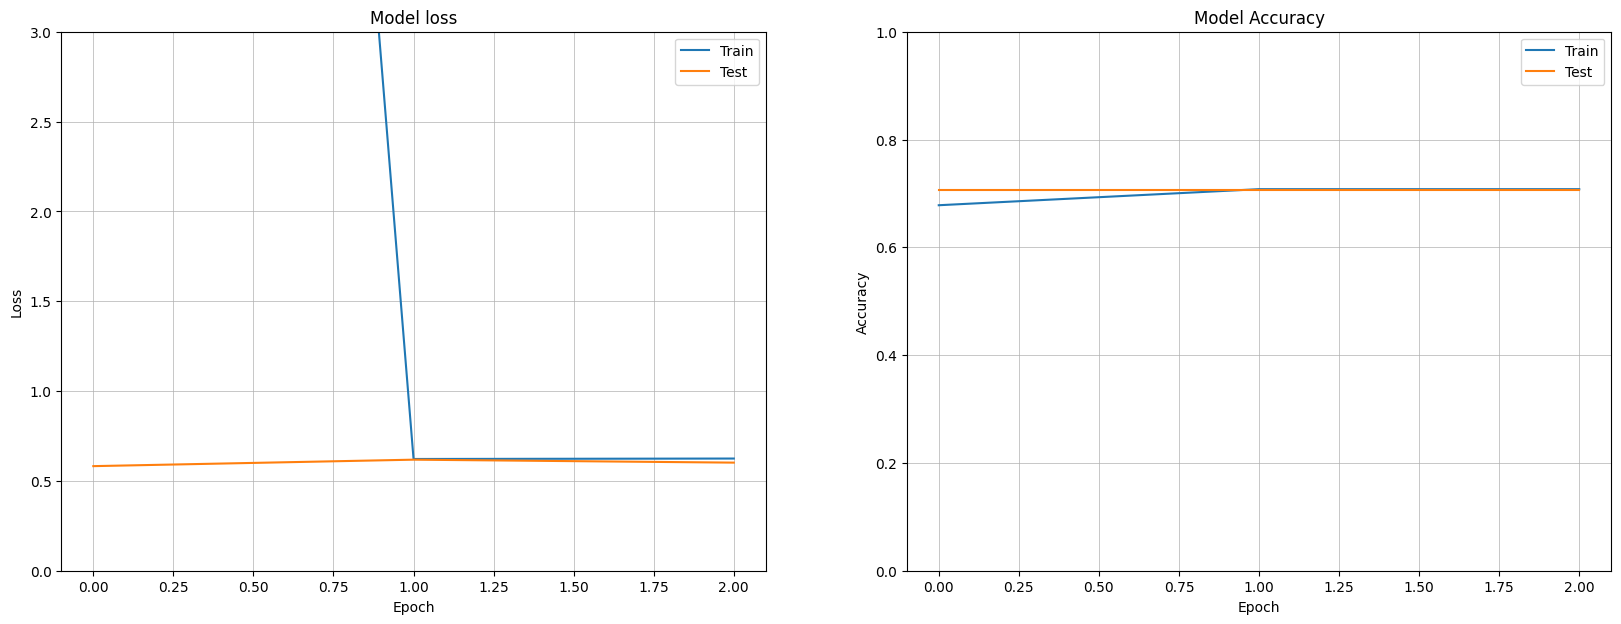

In [22]:
import matplotlib.pyplot as plt
plot_loss_accuracy(history)


## Plot des différentes images convutionnelles

In [ ]:
layers_outputs = [layer.output for layer in model.layers] # same as above
activation_model = Model(inputs=model.inputs, outputs=layers_outputs) # model with many outputs !
activations = activation_model.predict(X) # 11 predictions at once!
[activation.shape for activation in activations]

In [ ]:
# Selecting a random triangle
image_number = np.random.choice(np.where(y == 1)[0])

for layer_number in [0,2,4,6]:

    print(f"--- Observing the effect of the convolutional layer number {layer_number}... ---")
    print("")

    temp_number_kernels = model.layers[layer_number].weights[0].shape[-1]
    print(f"{temp_number_kernels} kernels were applied and here are all the activations of this Conv2D Layer:")

    fig, axes = plt.subplots(int(temp_number_kernels/4),4, figsize=(20,7))


    for ax, kernel_number in zip(axes.flat,range(temp_number_kernels)):
        activation = activations[layer_number][image_number][:, :, kernel_number]
        ax.imshow(activation, cmap="gray")

    plt.show()


In [ ]:

from anapath.image import dispatch_images_diag


Les fichiers ont été déplacés avec succès.


TypeError: 'module' object is not callable

In [2]:
!pip install anthropic

In [1]:
import anthropic

client = anthropic.Anthropic()

client.models.list(limit=20)

SyncPage[ModelInfo](data=[ModelInfo(id='claude-3-7-sonnet-20250219', created_at=datetime.datetime(2025, 2, 24, 0, 0, tzinfo=datetime.timezone.utc), display_name='Claude 3.7 Sonnet', type='model'), ModelInfo(id='claude-3-5-sonnet-20241022', created_at=datetime.datetime(2024, 10, 22, 0, 0, tzinfo=datetime.timezone.utc), display_name='Claude 3.5 Sonnet (New)', type='model'), ModelInfo(id='claude-3-5-haiku-20241022', created_at=datetime.datetime(2024, 10, 22, 0, 0, tzinfo=datetime.timezone.utc), display_name='Claude 3.5 Haiku', type='model'), ModelInfo(id='claude-3-5-sonnet-20240620', created_at=datetime.datetime(2024, 6, 20, 0, 0, tzinfo=datetime.timezone.utc), display_name='Claude 3.5 Sonnet (Old)', type='model'), ModelInfo(id='claude-3-haiku-20240307', created_at=datetime.datetime(2024, 3, 7, 0, 0, tzinfo=datetime.timezone.utc), display_name='Claude 3 Haiku', type='model'), ModelInfo(id='claude-3-opus-20240229', created_at=datetime.datetime(2024, 2, 29, 0, 0, tzinfo=datetime.timezone.ut

In [2]:
from anapath.params import *

import anthropic

client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key=API_KEY,
)
message = client.messages.create(
    model="claude-3-7-sonnet-20250219",
    max_tokens=1024,
    messages=[
        {"role": "user", "content": "Hello, Claude"}
    ]
)
print(message.content)

[TextBlock(citations=None, text="Hello! It's nice to meet you. How can I help you today? I'm ready to assist with information, answer questions, or just chat about whatever's on your mind.", type='text')]


In [ ]:
import anthropic

client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key="my_api_key",
)

# Replace placeholders like {{IMAGE_DESCRIPTION}} with real values,
# because the SDK does not support variables.
message = client.messages.create(
    model="claude-3-7-sonnet-20250219",
    max_tokens=20000,
    temperature=1,
    system="You are an expert pathologist specializing in breast tissue analysis. Your task is to examine a digital image of a breast tissue sample and provide a detailed analysis, including a diagnosis of whether cancer is present or not.\n",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "You are an expert pathologist specializing in breast tissue analysis. Your task is to examine a digital image of a breast tissue sample and provide a detailed analysis, including a diagnosis of whether cancer is present or not.\n\nFirst, you will be given a description of the microscopic image of the breast tissue sample:\n\n<image_description>"
                },
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": "<base64_encoded_image>"
                    }
                },
                {
                    "type": "text",
                    "text": "{{IMAGE_DESCRIPTION}}\n</image_description>\n\nNext, you will receive relevant patient information:\n\n<patient_info>\n{{PATIENT_INFO}}\n</patient_info>\n\nCarefully analyze the image description and patient information. Consider the following aspects in your analysis:\n1. Cellular structure and organization\n2. Nuclear characteristics (size, shape, chromatin pattern)\n3. Presence of abnormal cell divisions or mitotic figures\n4. Tissue architecture and any disruptions\n5. Presence of inflammatory cells or other abnormal features\n\nBased on your analysis, determine whether the sample indicates the presence of breast cancer or not. \n\nProvide your analysis and diagnosis in the following format:\n\n<analysis>\n[Detailed description of your observations and interpretation of the tissue sample]\n</analysis>\n\n<diagnosis>\n[Clear statement of whether breast cancer is present or not]\n</diagnosis>\n\n<confidence_level>\n[Your level of confidence in the diagnosis on a scale of 1-10, where 1 is least confident and 10 is most confident]\n</confidence_level>\n\n<recommendations>\n[Any recommendations for further tests or follow-up procedures, if necessary]\n</recommendations>\n\nRemember, your final output should only include the content within the <analysis>, <diagnosis>, <confidence_level>, and <recommendations> tags. Do not include any additional commentary or thought processes outside of these specified sections."
                }
            ]
        }
    ],
    thinking={
        "type": "enabled",
        "budget_tokens": 16000
    }
)
print(message.content)